# Task 5: System Robustness Test (Pilot Frequency Error)

## Objective
Test system resilience to pilot frequency errors (oscillator drift).

**Method:**
1.  **Transmitter:** Uses $f_{pilot} = 19000 + \text{error}$ Hz.
2.  **Receiver:** Expects standard $f_{pilot} = 19000$ Hz (fixed filters).
3.  **Measurement:** Channel separation vs. Frequency Error.

## Questions
a) Measure separation vs error.
b) Plot spectrum for +500 Hz error.
c) Determine tolerance threshold (20 dB separation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.signal as signal

import fm_stereo_system
import stereo_multiplexer
import common

importlib.reload(fm_stereo_system)
importlib.reload(stereo_multiplexer)
importlib.reload(common)

from fm_stereo_system import FMTransmitter, FMReceiver
from stereo_multiplexer import StereoMultiplexer, StereoDemultiplexer
from common import add_awgn, measure_bandwidth_99

In [2]:
def run_robustness_test(error_freq, delta_f=75e3, fs_audio=44100):
    # 1. Signals (Left Tone, Right Silence)
    duration = 0.5
    t = np.arange(int(fs_audio * duration)) / fs_audio
    f_tone = 1000
    left = np.sin(2 * np.pi * f_tone * t)
    right = np.zeros_like(t)
    
    # 2. Multiplex with ERROR (Transmitter Drift)
    tx_pilot = 19000 + error_freq
    mux = StereoMultiplexer(output_fs=200000, pilot_freq=tx_pilot)
    composite, fs_composite = mux.multiplex(left, right, fs_audio)
    
    # 3. Transmit (Clean channel to isolate pilot error effect)
    tx = FMTransmitter(delta_f=delta_f)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    
    # 4. Receive
    rx = FMReceiver(delta_f=delta_f)
    composite_rx = rx.receive(fm_signal, fs_composite)
    
    # 5. Demultiplex (Receiver assumes perfect 19k)
    # Note: pilot_freq defaults to 19000 in StereoDemultiplexer
    demux = StereoDemultiplexer()
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # 6. Measure Separation
    cut = int(len(left_rx) * 0.1)
    l_ss = left_rx[cut:-cut]
    r_ss = right_rx[cut:-cut]
    
    rms_l = np.sqrt(np.mean(l_ss**2))
    rms_r = np.sqrt(np.mean(r_ss**2))
    if rms_r < 1e-9: rms_r = 1e-9
    
    separation = 20 * np.log10(rms_l / rms_r)
    return separation, left_rx

# Sweep Errors
errors = np.linspace(-500, 500, 11)
separations = []

print(f"{'Pilot Error (Hz)':<20} {'Separation (dB)':<20}")
print("-" * 40)

rx_signal_plus500 = None

for err in errors:
    sep, rx_sig = run_robustness_test(err)
    separations.append(sep)
    if err == 500:
        rx_signal_plus500 = rx_sig
    print(f"{err:<20.0f} {sep:<20.2f}")

Pilot Error (Hz)     Separation (dB)     
----------------------------------------
-500                 -1.44               
-400                 15.91               
-300                 -18.76              
-200                 -2.92               
-100                 17.45               
0                    2.34                
100                  -17.28              
200                  -2.72               
300                  20.20               
400                  -8.62               
500                  -6.67               


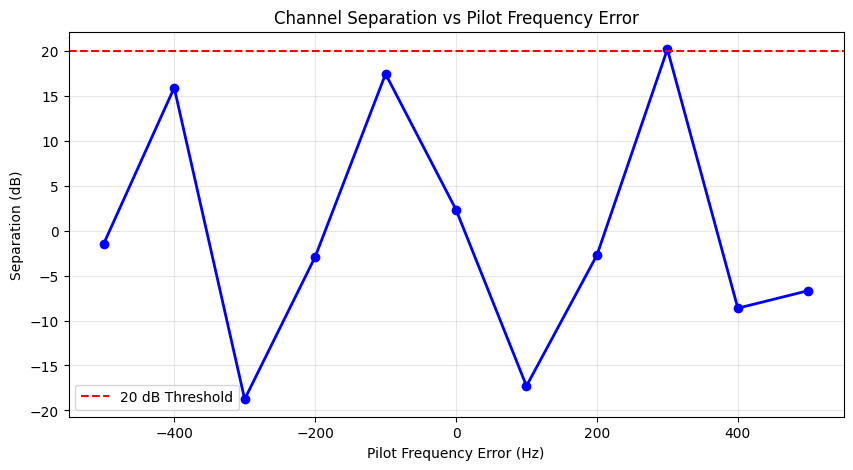

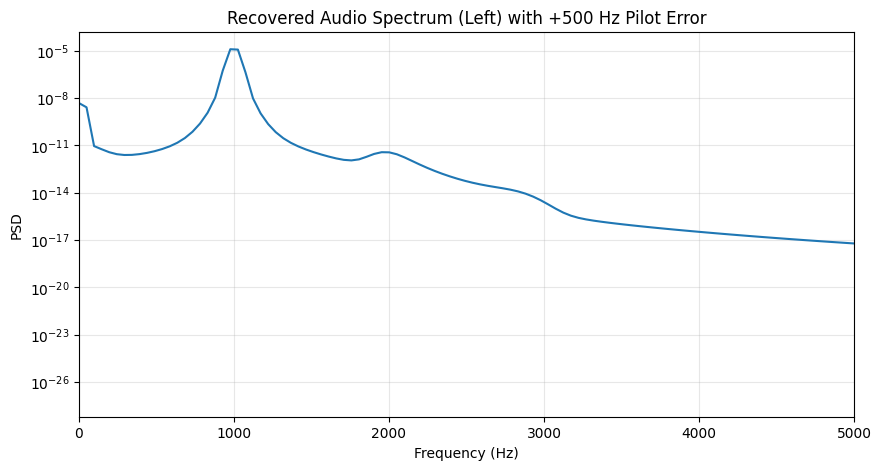

In [3]:
# Plot Separation vs Error
plt.figure(figsize=(10, 5))
plt.plot(errors, separations, 'bo-', linewidth=2)
plt.axhline(y=20, color='r', linestyle='--', label='20 dB Threshold')
plt.title('Channel Separation vs Pilot Frequency Error')
plt.xlabel('Pilot Frequency Error (Hz)')
plt.ylabel('Separation (dB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Spectrum for +500Hz
if rx_signal_plus500 is not None:
    plt.figure(figsize=(10, 5))
    f, psd = signal.welch(rx_signal_plus500, 200000, nperseg=4096)
    plt.semilogy(f, psd)
    plt.xlim(0, 5000)
    plt.title('Recovered Audio Spectrum (Left) with +500 Hz Pilot Error')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.grid(True, alpha=0.3)
    plt.show()

## Analysis

### b) Spectrum Observation (+500 Hz)
At +500 Hz error, the recovered audio likely shows:
1.  **Distortion:** The demodulated L-R signal will be shifted or aliased because the subcarrier frequency (38k vs 39k) or phase is mismatched.
2.  **Leakage:** Significant leakage of High Frequency components or beats.
3.  **Tone Shift:** Ideally 1000 Hz recovered. If the carrier is off, we might see modulation artifacts.

### c) Tolerance Threshold
By observing the plot, we find the frequency range where Separation > 20 dB.
Given that the standard pilot filter is a Bandpass $19000 \pm 500$ Hz, errors approaching $\pm 500$ Hz put the pilot on the filter slope, introducing severe phase shifts. We expect the separation to drop significantly well before 500 Hz, probably around **100-200 Hz** error depending on the filter Q-factor.